In [7]:
import os, sys, numpy as np, time, random
import matplotlib.pyplot as plt

# Set up the source path (adjust as needed for your project structure)
notebooks_path = os.path.abspath(os.getcwd())
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import custom functions for adapted measures and optimal solvers
from optimal_code.utils import *
from optimal_code.optimal_solver import *


from trees.build_trees_from_paths import *
from trees.treeVisualization import *
from adapted_empirical_measure.AEM_grid import *

In [8]:
# ----------------------------------------------------------------------------
# Define an AR(3) simulation function with Gaussian noise
# ----------------------------------------------------------------------------
def ar3_simulation(n_sample, T, phi, sigma, seed):
    """
    Simulates an AR(3) process with Gaussian noise:
    
        X_t = phi[0]*X_{t-1} + phi[1]*X_{t-2} + phi[2]*X_{t-3} + sigma * Z_t,
    
    where Z_t ~ N(0,1). The process is simulated for T time steps 
    (excluding the initial conditions). For an AR(3) process, we need 
    three initial values; here, we set X[0], X[1], and X[2] to 0.
    
    Parameters:
      n_sample: int
          Number of sample paths.
      T: int
          Total number of time steps (must be >= 3). The returned array
          will have shape (T+1, n_sample), with indices 0,...,T.
      phi: list or array of length 3
          AR(3) coefficients.
      sigma: float
          Noise scale.
      seed: int
          Random seed.
      
    Returns:
      X: np.ndarray of shape (T+1, n_sample)
    """
    np.random.seed(seed)
    X = np.zeros((T+1, n_sample))
    # Set initial conditions for t = 0, 1, 2
    X[0, :] = 0.0
    X[1, :] = 0.0
    X[2, :] = 0.0
    for t in range(3, T+1):
        Z = np.random.normal(loc=0.0, scale=1.0, size=n_sample)
        X[t, :] = phi[0]*X[t-1, :] + phi[1]*X[t-2, :] + phi[2]*X[t-3, :] + sigma * Z
    return X

# To check the goal here is to have a model with non markovian Behavior

Parameter choosed kind of randomly we care about the past -> 3 time step looking back not only 1

In [17]:
# ----------------------------------------------------------------------------
# Experiment Parameters
# ----------------------------------------------------------------------------
T = 10               # Total time steps (we simulate indices 0,1,2 as initial and t=3,4 by AR recursion)

# AR(3) parameters for Process X (e.g., more persistent, lower volatility)
phi_x = [0.6, 0.2, 0.1]  
sigma_x = 1.0

# AR(3) parameters for Process Y (e.g., less persistent, higher volatility)
phi_y = [0.3, 0.1, 0.05]
sigma_y = 1.5

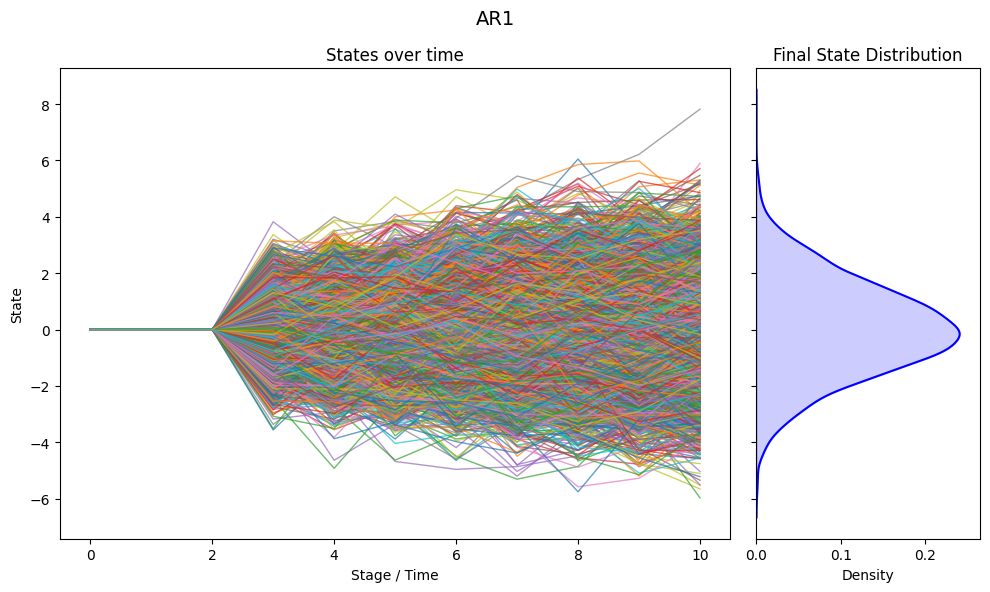

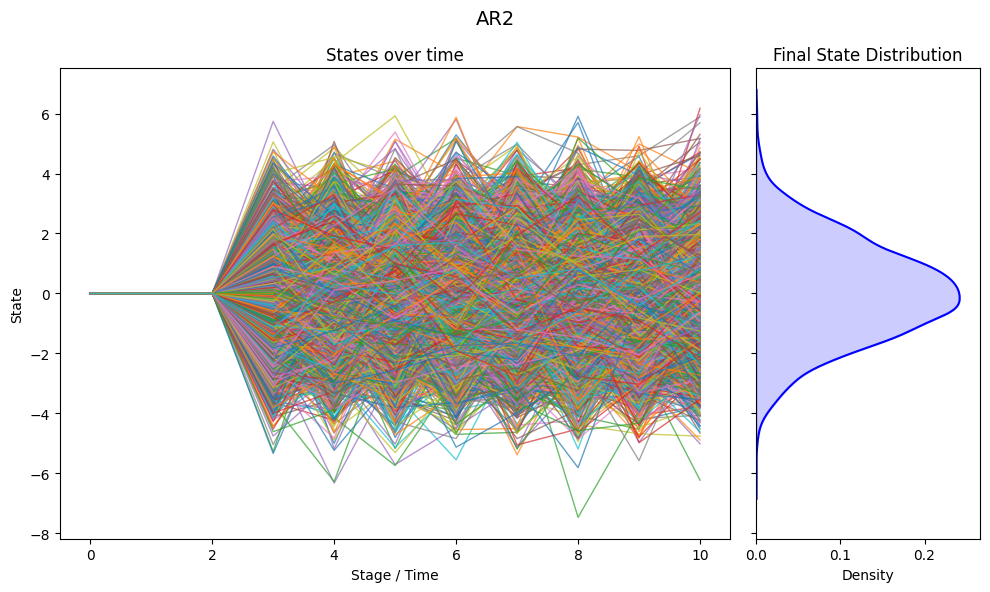

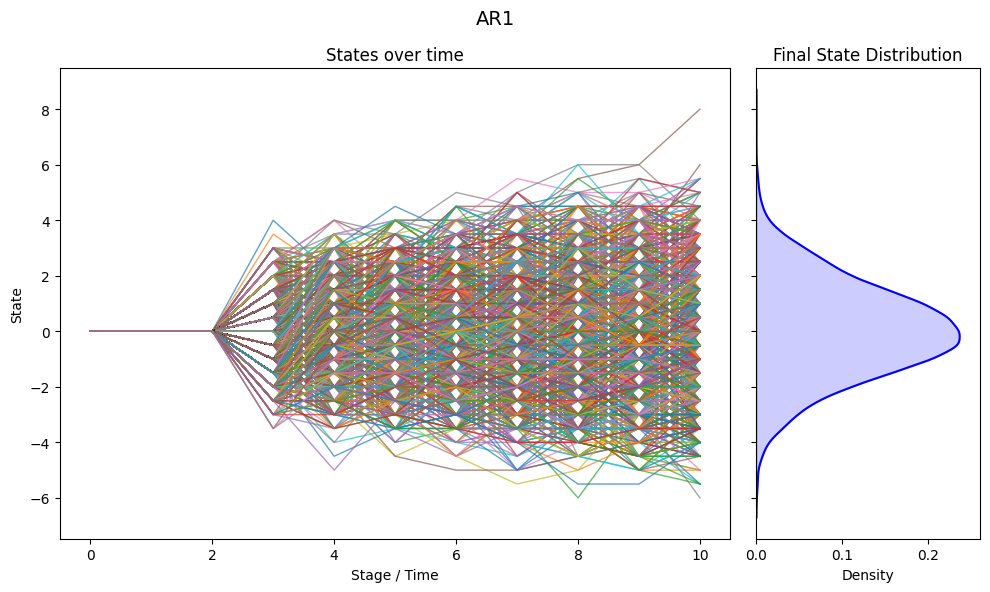

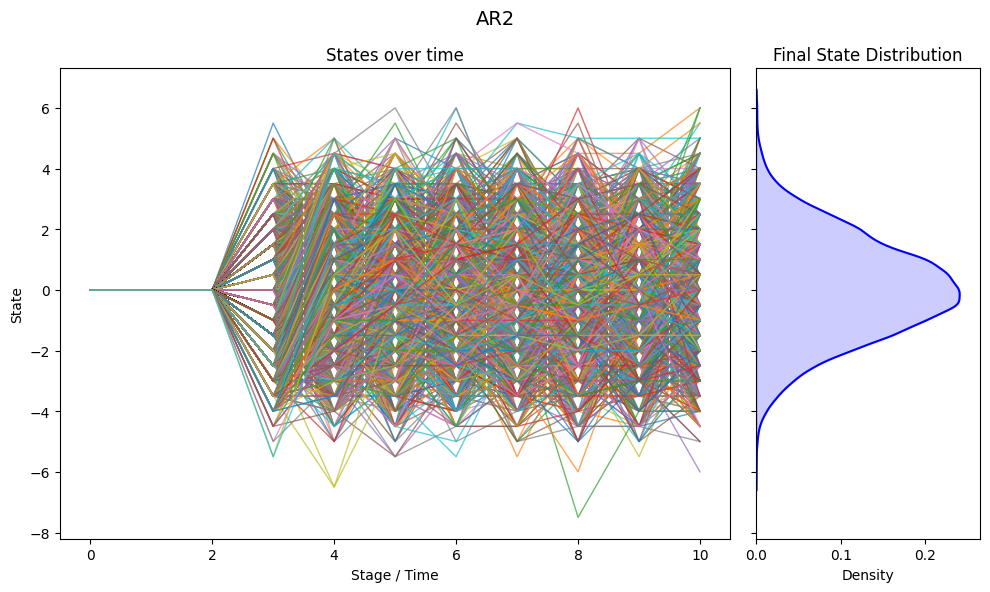

In [13]:
n_sample = 5000
seed = 44

X = ar3_simulation(n_sample, T, phi_x, sigma_x, seed)
Y = ar3_simulation(n_sample, T, phi_y, sigma_y, seed)

iid_weights = np.full(n_sample, 1 / n_sample)

root = build_tree_from_paths(X.T, iid_weights)
visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="AR1",
)

root = build_tree_from_paths(Y.T, iid_weights)

visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="AR2",
)

fixed_grid = 0.5 # <- Large grid for visualization

new_sample_paths, new_weights = uniform_empirical_grid_measure(X.T, fixed_grid, use_weights=True) # Grid with number of grid points as in papers [0,1] divided into: 1/N^r with R=1/(T+1).
root = build_tree_from_paths(new_sample_paths, new_weights)

visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="AR1",
)

new_sample_paths, new_weights = uniform_empirical_grid_measure(Y.T, fixed_grid, use_weights=True) # Grid with number of grid points as in papers [0,1] divided into: 1/N^r with R=1/(T+1).
root = build_tree_from_paths(new_sample_paths, new_weights)

visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="AR2",
)

In [14]:
sample_sizes = [500, 1000, 3000, 5000, 7500]  # Small number of samples <- just to run something quickly

n_runs = 10         # Number of independent runs per sample size

# small number of samples and not optimal gird size it is just to run something

In [16]:
# ----------------------------------------------------------------------------
# Run Experiments Over Different Sample Sizes
# ----------------------------------------------------------------------------

results = {}


for n_sample in sample_sizes:
    distances_runs = np.zeros(n_runs)
    times_runs = np.zeros(n_runs)
    
    print(f"\nRunning experiments for sample size: {n_sample}")
    for run in range(n_runs):
        # Use a new random seed for each run
        seed = np.random.randint(10000)
        
        # Simulate AR(3) paths for both processes
        X = ar3_simulation(n_sample, T, phi_x, sigma_x, seed)
        Y = ar3_simulation(n_sample, T, phi_y, sigma_y, seed)
        
        # Convert raw paths to adapted paths via grid quantization
        adaptedX = path2adaptedpath(X, delta_n=fixed_grid)
        adaptedY = path2adaptedpath(Y, delta_n=fixed_grid)
        
        # Build quantization mapping using the union of all grid values
        q2v = np.unique(np.concatenate([adaptedX, adaptedY], axis=0))
        v2q = {k: v for v, k in enumerate(q2v)}
        qX = np.array([[v2q[x] for x in y] for y in adaptedX])
        qY = np.array([[v2q[x] for x in y] for y in adaptedY])
        # Ensure proper ordering: transpose so shape becomes (n_sample, T+1)
        qX = sort_qpath(qX.T)
        qY = sort_qpath(qY.T)
        
        # Obtain the conditional measures (non-Markovian)
        mu_x = qpath2mu_x(qX)
        nu_y = qpath2mu_x(qY)
        
        # Represent these measures as lists for the nested solver
        mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn = list_repr_mu_x(mu_x, q2v)
        nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn = list_repr_mu_x(nu_y, q2v)
        
        # Compute the adapted Wasserstein squared distance using the non-Markovian solver
        t_start = time.perf_counter()
        AW_2square = nested2_parallel(mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn,
                                      nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn,
                                      n_processes=30)
        elapsed = time.perf_counter() - t_start
        
        distances_runs[run] = AW_2square
        times_runs[run] = elapsed
        
        print(f"Sample size {n_sample}, Run {run+1}: AW_2^2 = {AW_2square:.4f}, Time = {elapsed:.4f} s")
    
    results[n_sample] = {"distances": distances_runs, "times": times_runs}


Running experiments for sample size: 500


100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 820.87it/s]

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 822.02it/s]

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 774.97it/s]

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 656.09it/s]

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 542.36it/s]

100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 480.51it/s]

100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 523.65it/s]

100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 439.43it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 540.16it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 484.41it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 315.47it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 314.80it/s]

100%|███████████

Sample size 500, Run 1: AW_2^2 = 16.7670, Time = 3.8548 s


100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 715.33it/s]

100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 817.14it/s]

100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 819.47it/s]

100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 820.48it/s]

  0%|                                                    | 0/16 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 809.94it/s]

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 667.86it/s]

100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 543.88it/s]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 440.81it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 622.03it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 393.73it/s]

100%|███████████

Sample size 500, Run 2: AW_2^2 = 16.7120, Time = 3.9748 s


100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 811.76it/s]


  0%|                                                    | 0/17 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 641.32it/s]

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 543.10it/s]

100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 517.71it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 534.31it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 609.11it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 176.28it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 230.59it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 233.06it/s]


  0%|                                                     | 0/1 [00:00<?, ?it/s]


100%|████████

Sample size 500, Run 3: AW_2^2 = 17.1700, Time = 3.8012 s


100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 636.83it/s]

  0%|                                                    | 0/16 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 814.89it/s]

100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 490.06it/s]

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 416.50it/s]

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 526.65it/s]


  0%|                                                    | 0/10 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 483.98it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 307.12it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 213.49it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 221.30it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 216.76it/s]


100%|█████████

Sample size 500, Run 4: AW_2^2 = 18.1014, Time = 3.8259 s


  0%|                                                    | 0/17 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 817.75it/s]

100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 640.01it/s]

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 803.80it/s]

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 446.89it/s]

100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 543.66it/s]

100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 539.93it/s]

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 444.70it/s]


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 440.25it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 380.66it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 419.21it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 462.05it/s]

100%|██████████

Sample size 500, Run 5: AW_2^2 = 17.0142, Time = 3.8397 s


100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 819.12it/s]

100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 814.91it/s]

100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 517.48it/s]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 465.64it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 288.92it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 308.60it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 317.73it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 230.24it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 221.74it/s]

0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 448.35it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 500.87it/s]
100%|█████████████

Sample size 500, Run 6: AW_2^2 = 16.1731, Time = 3.9487 s


100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 709.00it/s]

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 815.86it/s]

100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 473.94it/s]

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 344.35it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 540.87it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 317.34it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 225.21it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 182.73it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 224.58it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 321.15it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 218.33it/s]
100%|█████████████

Sample size 500, Run 7: AW_2^2 = 16.6111, Time = 3.9930 s


100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 815.92it/s]

  0%|                                                    | 0/17 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 811.95it/s]

100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 828.00it/s]

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 818.22it/s]

100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 530.10it/s]

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 445.81it/s]

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 455.12it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 288.17it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 383.29it/s]

  0%|                                                     | 0/3 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 233.56it/s]

100%|███████████

Sample size 500, Run 8: AW_2^2 = 16.2716, Time = 3.9426 s


100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 639.01it/s]

100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 730.09it/s]

100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 712.65it/s]

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 808.89it/s]

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 682.04it/s]

  0%|                                                    | 0/10 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 497.35it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 242.95it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 504.30it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 206.54it/s]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 236.65it/s]

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 225.62it/s]

  0%|          

Sample size 500, Run 9: AW_2^2 = 17.3466, Time = 3.9382 s


  0%|                                                    | 0/17 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 808.17it/s]

100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 819.11it/s]

100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 813.03it/s]


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 598.36it/s]

100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 414.18it/s]

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 462.58it/s]

100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 482.40it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 321.42it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 532.60it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 396.35it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 314.99it/s]

100%|██████████

Sample size 500, Run 10: AW_2^2 = 17.3526, Time = 3.9818 s

Running experiments for sample size: 1000


  0%|                                                    | 0/33 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 33/33 [00:00<00:00, 412.24it/s]

100%|██████████████████████████████████████████| 28/28 [00:00<00:00, 271.59it/s]

  0%|                                                    | 0/28 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 28/28 [00:00<00:00, 197.10it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 212.68it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 498.71it/s]

  0%|                                                     | 0/4 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 309.59it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 450.18it/s]
0it [00:00, ?it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1737.49it/s]

Sample size 1000, Run 1: AW_2^2 = 17.3467, Time = 8.1523 s


  0%|                                                    | 0/33 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 33/33 [00:00<00:00, 416.77it/s]

100%|██████████████████████████████████████████| 33/33 [00:00<00:00, 377.65it/s]

100%|██████████████████████████████████████████| 33/33 [00:00<00:00, 415.19it/s]

100%|██████████████████████████████████████████| 33/33 [00:00<00:00, 381.87it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 459.70it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 455.21it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3160.74it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 482.77it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 483.21it/s]


0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 221.80it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0

Sample size 1000, Run 2: AW_2^2 = 16.5499, Time = 7.3335 s


100%|██████████████████████████████████████████| 33/33 [00:00<00:00, 413.24it/s]

100%|██████████████████████████████████████████| 33/33 [00:00<00:00, 392.76it/s]


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 212.04it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 460.10it/s]

0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 424.52it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 291.05it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]



0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]

Sample size 1000, Run 3: AW_2^2 = 16.9146, Time = 7.3043 s


  0%|                                                    | 0/33 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 34/34 [00:00<00:00, 413.68it/s]

100%|██████████████████████████████████████████| 33/33 [00:00<00:00, 413.92it/s]

100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 173.52it/s]

100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 161.48it/s]

100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 379.61it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 203.45it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 530.99it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 198.37it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 453.00it/s]



100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 466.66it/s

Sample size 1000, Run 4: AW_2^2 = 16.9774, Time = 7.4227 s


100%|██████████████████████████████████████████| 33/33 [00:00<00:00, 414.12it/s]

100%|██████████████████████████████████████████| 33/33 [00:00<00:00, 413.80it/s]

100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 247.24it/s]

100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 118.89it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 477.11it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 468.58it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 248.27it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]





0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00,

Sample size 1000, Run 5: AW_2^2 = 16.7132, Time = 7.1248 s


100%|██████████████████████████████████████████| 34/34 [00:00<00:00, 414.47it/s]

  0%|                                                    | 0/33 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 186.76it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 158.18it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 466.09it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1381.07it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 368.28it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 135.82it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 180.96it/s]

0it [00:00, ?it/s]█

Sample size 1000, Run 6: AW_2^2 = 16.7139, Time = 7.3228 s


100%|██████████████████████████████████████████| 34/34 [00:00<00:00, 413.99it/s]

100%|██████████████████████████████████████████| 34/34 [00:00<00:00, 409.31it/s]

100%|██████████████████████████████████████████| 33/33 [00:00<00:00, 315.93it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 216.96it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 547.42it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 1314.42it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

100%|███████████████████████████████████████████

Sample size 1000, Run 7: AW_2^2 = 16.7281, Time = 7.0905 s


100%|██████████████████████████████████████████| 34/34 [00:00<00:00, 415.15it/s]

100%|██████████████████████████████████████████| 33/33 [00:00<00:00, 270.06it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 247.06it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 121.46it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 498.43it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 526.46it/s]
0it [00:00, ?it/s]



0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 262.92it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]



0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:

Sample size 1000, Run 8: AW_2^2 = 17.2427, Time = 6.7877 s


100%|██████████████████████████████████████████| 33/33 [00:00<00:00, 404.74it/s]

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 201.85it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 559.99it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2818.75it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 209.32it/s]

0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 543.51it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 184.73it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 208.09it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:

Sample size 1000, Run 9: AW_2^2 = 17.0117, Time = 6.8359 s


100%|██████████████████████████████████████████| 34/34 [00:00<00:00, 412.65it/s]

100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 224.88it/s]

100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 249.20it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 156.79it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 452.51it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 193.62it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 429.48it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 471.69it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 1162.

Sample size 1000, Run 10: AW_2^2 = 17.2610, Time = 7.0047 s

Running experiments for sample size: 3000


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 421.54it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 444.03it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 491.48it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 449.45it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 614.91it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]













0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:0

Sample size 3000, Run 1: AW_2^2 = 16.3597, Time = 21.7614 s


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 118.63it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 452.61it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 2481.84it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 277.55it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 436.23it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 443.65it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 585

Sample size 3000, Run 2: AW_2^2 = 16.3522, Time = 21.5774 s


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 136.15it/s]

100%|███████████████████████████████████████████| 67/67 [00:00<00:00, 69.31it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 106.68it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 183.43it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]


0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 405.05it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 424.27it/s]
0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 2746.76it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:00, ?

Sample size 3000, Run 3: AW_2^2 = 16.4041, Time = 21.9481 s


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 137.05it/s]

100%|██████████████████████████████████████████| 99/99 [00:00<00:00, 136.33it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 172.70it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 401.14it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 462.64it/s]
0it [00:00, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 427.64it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 445.11it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?,

Sample size 3000, Run 4: AW_2^2 = 16.4844, Time = 21.8754 s


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 129.73it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 425.04it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 428.12it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 374.16it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 447.39it/s]

0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 498.20it/s]

0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 465.57it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]██████████████████████████████| 1/1 [00

Sample size 3000, Run 5: AW_2^2 = 16.5952, Time = 21.9176 s


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 128.92it/s]


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 131.99it/s]

 68%|███████████████████████████▉             | 68/100 [00:00<00:00, 120.93it/s]

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 130.98it/s]

 95%|██████████████████████████████████████▉  | 95/100 [00:00<00:00, 127.15it/s]

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 127.18it/s]

100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 54.29it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 441.37it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 423.03it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 510.69it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00

Sample size 3000, Run 6: AW_2^2 = 16.5535, Time = 22.1017 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 421.96it/s]



100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 542.39it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 246.39it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 192.04it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 588.59it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]







0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<0

Sample size 3000, Run 7: AW_2^2 = 16.4375, Time = 21.7743 s


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 121.63it/s]

100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 58.69it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 182.07it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 452.22it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 417.30it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 520.19it/s]


0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 460.51it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 231.05it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]

100%|█████████████████████████████████████████

Sample size 3000, Run 8: AW_2^2 = 16.2549, Time = 21.9282 s


 89%|████████████████████████████████████▍    | 89/100 [00:00<00:00, 108.46it/s]

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 114.12it/s]

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 123.85it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 217.38it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 419.93it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 440.25it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 386.68it/s]

0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 362.55it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 587.03it/s]
0it [00:00, ?it/s]
0it [0

Sample size 3000, Run 9: AW_2^2 = 16.1519, Time = 22.0803 s


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 121.19it/s]

100%|██████████████████████████████████████████| 99/99 [00:00<00:00, 127.60it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 109.28it/s]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 146.26it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 185.58it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 192.15it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 437.32it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]



0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 2551.28it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it 

Sample size 3000, Run 10: AW_2^2 = 16.7096, Time = 22.0545 s

Running experiments for sample size: 5000


100%|█████████████████████████████████████████| 166/166 [00:02<00:00, 77.57it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 362.26it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 422.13it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 498.31it/s]

0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 218.60it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 587.93it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]




0it [00:00, ?it/s]














0it [00:00, ?it/s]
0it [00:00, ?it/s]


Sample size 5000, Run 1: AW_2^2 = 15.8564, Time = 49.7141 s


100%|█████████████████████████████████████████| 166/166 [00:02<00:00, 75.47it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 210.55it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 410.00it/s]


  0%|                                                     | 0/1 [00:00<?, ?it/s]


0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 505.16it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 1172.90it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]













0it [00:00, ?it/s]
0it [

Sample size 5000, Run 2: AW_2^2 = 16.1366, Time = 48.5571 s


100%|█████████████████████████████████████████| 167/167 [00:02<00:00, 71.06it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 91.59it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 340.73it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 395.80it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 400.26it/s]


0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 480.17it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 583.51it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]






0it [00:00, ?it/s]



0it [00:00, ?it/s]





0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it

Sample size 5000, Run 3: AW_2^2 = 15.7729, Time = 48.5079 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 408.36it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 389.12it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 420.90it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 424.40it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 1125.38it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]










0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 2229.83it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [

Sample size 5000, Run 4: AW_2^2 = 16.2002, Time = 48.3011 s


100%|███████████████████████████████████████████| 92/92 [00:01<00:00, 58.87it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 416.27it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 404.00it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 424.57it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 172.90it/s]


0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 480.01it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 573.93it/s

Sample size 5000, Run 5: AW_2^2 = 15.6149, Time = 48.2547 s


100%|█████████████████████████████████████████| 167/167 [00:02<00:00, 72.25it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 210.19it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 179.44it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 403.65it/s]

0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 427.90it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 279.83it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 1072.44it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Sample size 5000, Run 6: AW_2^2 = 15.8991, Time = 47.7656 s


 92%|█████████████████████████████████████▌   | 152/166 [00:01<00:00, 81.74it/s]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 91.69it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 419.89it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]



0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]███████████████████████

Sample size 5000, Run 7: AW_2^2 = 16.0399, Time = 48.2656 s


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 126.71it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 387.14it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]



0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 440.35it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 164.21it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1173.23it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]





0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]












0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it 

Sample size 5000, Run 8: AW_2^2 = 16.2540, Time = 48.5606 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 222.70it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 432.45it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 399.38it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 382.80it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 486.52it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 399.88it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 445.21it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 1115.51it/s]
0it [00:00, ?it/

Sample size 5000, Run 9: AW_2^2 = 16.0714, Time = 48.6657 s


100%|█████████████████████████████████████████| 166/166 [00:02<00:00, 76.76it/s]

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 904.37it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 463.66it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 269.09it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 392.98it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 421.50it/s]

0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 240.54it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 405.60it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 466.40it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 6

Sample size 5000, Run 10: AW_2^2 = 16.2085, Time = 48.6875 s

Running experiments for sample size: 7500


100%|█████████████████████████████████████████| 249/249 [00:05<00:00, 47.82it/s]

100%|█████████████████████████████████████████| 249/249 [00:05<00:00, 48.35it/s]

100%|█████████████████████████████████████████| 119/119 [00:04<00:00, 27.08it/s]

100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 128.85it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 452.07it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 184.95it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 401.79it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 386.68it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2514.57it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 265.68it/s]


0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 1301.77it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0

Sample size 7500, Run 1: AW_2^2 = 15.6303, Time = 89.0376 s


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2794.34it/s]

0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 445.44it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1127.80it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]














0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 4181

Sample size 7500, Run 2: AW_2^2 = 15.8422, Time = 91.7539 s


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 213.51it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 409.52it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 360.40it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 188.21it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 416.43it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 483.10it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 259.26it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 566.80it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0

Sample size 7500, Run 3: AW_2^2 = 15.8426, Time = 87.6398 s


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2576.35it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 389.66it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 378.62it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 376.58it/s]

0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 385.83it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 467.12it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 355.72it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 

Sample size 7500, Run 4: AW_2^2 = 15.8110, Time = 89.5463 s


100%|█████████████████████████████████████████| 249/249 [00:04<00:00, 51.60it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 403.88it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 397.26it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 412.74it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 390.60it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 463.46it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1092.55it/s]
0it [00:00, ?it/s]




0it [00:00, ?

Sample size 7500, Run 5: AW_2^2 = 15.6175, Time = 86.5391 s


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 146.11it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 208.67it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 385.19it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 406.82it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 393.09it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 402.95it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1516.38it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]████████████████████████

Sample size 7500, Run 6: AW_2^2 = 15.7044, Time = 90.1401 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 403.22it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 402.72it/s]

0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 377.83it/s]
  0%|                                                     | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 389.84it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 465.46it/s]

0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 375.33it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
100%|████████████████████████████████████████████| 1/1 [

Sample size 7500, Run 7: AW_2^2 = 16.0304, Time = 91.9956 s


 96%|███████████████████████████████████████▌ | 240/249 [00:04<00:00, 54.30it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 371.74it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 370.72it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 409.72it/s]

0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 445.35it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 408.80it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]                                        | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 705.28it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/

Sample size 7500, Run 8: AW_2^2 = 16.0709, Time = 90.9702 s


 79%|████████████████████████████████▍        | 197/249 [00:03<00:01, 44.50it/s]

100%|█████████████████████████████████████████| 249/249 [00:04<00:00, 51.95it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 397.75it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]


  0%|                                                     | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 474.63it/s]

0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 433.56it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 1153.23it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]




0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]


















0it [00:00, ?it/s]             

Sample size 7500, Run 9: AW_2^2 = 15.8986, Time = 89.9861 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 359.01it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 415.69it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 420.73it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2820.65it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]███████████████████████████████| 1/1 [00:00<00:00, 434.28it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 1106.09it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]











0it [00:00, ?it/s]██████████████████████████████| 1/1 [00:00<00:00, 1941.81it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00

Sample size 7500, Run 10: AW_2^2 = 15.6794, Time = 89.5727 s


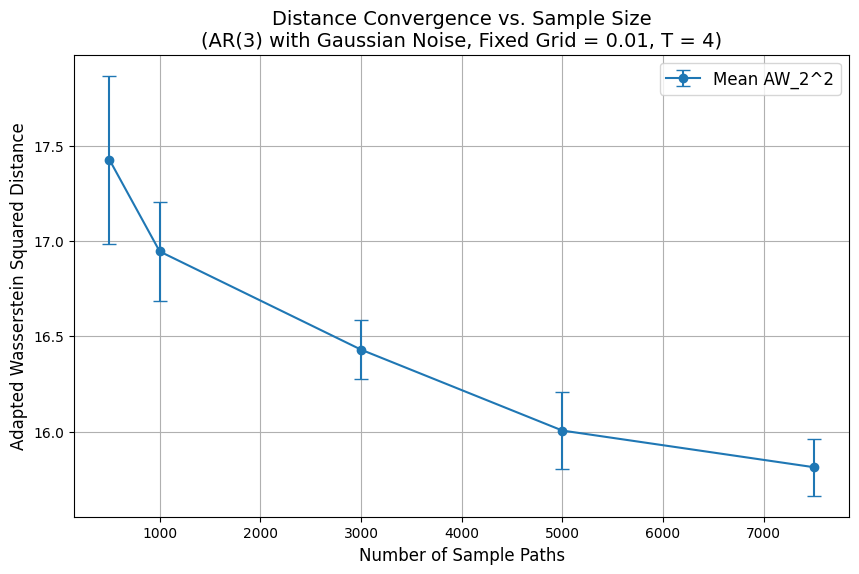

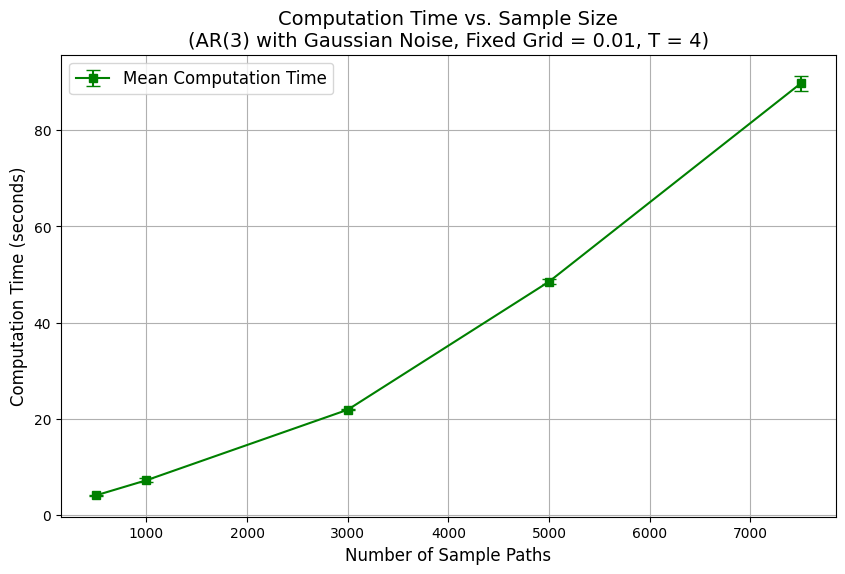

In [19]:
# ----------------------------------------------------------------------------
# Aggregating Results
# ----------------------------------------------------------------------------
sample_list = sorted(results.keys())
mean_distances = []
std_distances = []
mean_times = []
std_times = []

for n_sample in sample_list:
    data = results[n_sample]
    dists = data["distances"]
    times = data["times"]
    mean_distances.append(np.mean(dists))
    std_distances.append(np.std(dists))
    mean_times.append(np.mean(times))
    std_times.append(np.std(times))

# ----------------------------------------------------------------------------
# Plotting the Results
# ----------------------------------------------------------------------------

# Plot 1: Adapted Wasserstein Squared Distance vs. Sample Size
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_distances, yerr=std_distances, fmt="o-", capsize=5, label="Mean AW_2^2")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Adapted Wasserstein Squared Distance", fontsize=12)
plt.title("Distance Convergence vs. Sample Size\n(AR(3) with Gaussian Noise, Fixed Grid = 0.01, T = 4)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 2: Computation Time vs. Sample Size
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_times, yerr=std_times, fmt="s-", capsize=5, color="green", label="Mean Computation Time")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Computation Time (seconds)", fontsize=12)
plt.title("Computation Time vs. Sample Size\n(AR(3) with Gaussian Noise, Fixed Grid = 0.01, T = 4)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# The parameter (grid and sample sizes) are not the best I only choose them to run somthing fast